In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

import lime
import lime.lime_tabular
import shap

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [ ]:
df = pd.read_csv("")

In [9]:
df = pd.read_csv("biflow_normal.csv")
attack = pd.read_csv("biflow_mqtt_bruteforce.csv")
df.head()

,ip_src,ip_dst,prt_src,prt_dst,proto,fwd_num_pkts,bwd_num_pkts,fwd_mean_iat,bwd_mean_iat,fwd_std_iat,...,bwd_max_pkt_len,fwd_num_bytes,bwd_num_bytes,fwd_num_psh_flags,bwd_num_psh_flags,fwd_num_rst_flags,bwd_num_rst_flags,fwd_num_urg_flags,bwd_num_urg_flags,is_attack
0,10.0.0.5,192.168.1.7,56572,1883,6,7,5,0.000237,0.000203,0.000218,...,60.0,444,272,3,1,0,0,0,0,0
1,10.0.0.11,192.168.1.7,51906,1883,6,7,5,0.000242,0.000243,0.000207,...,60.0,483,272,3,1,0,0,0,0,0
2,10.0.0.14,192.168.1.7,54202,1883,6,7,5,0.000284,0.000349,0.000323,...,60.0,531,272,3,1,0,0,0,0,0
3,10.0.0.12,192.168.1.7,39782,1883,6,7,5,0.001038,0.000968,0.000895,...,60.0,462,272,3,1,0,0,0,0,0
4,10.0.0.13,192.168.1.7,38052,1883,6,7,5,0.001039,0.000968,0.000776,...,60.0,463,272,3,1,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86008 entries, 0 to 86007
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ip_src             86008 non-null  object 
 1   ip_dst             86008 non-null  object 
 2   prt_src            86008 non-null  int64  
 3   prt_dst            86008 non-null  int64  
 4   proto              86008 non-null  int64  
 5   fwd_num_pkts       86008 non-null  int64  
 6   bwd_num_pkts       86008 non-null  int64  
 7   fwd_mean_iat       86008 non-null  float64
 8   bwd_mean_iat       86008 non-null  float64
 9   fwd_std_iat        86008 non-null  float64
 10  bwd_std_iat        86008 non-null  float64
 11  fwd_min_iat        86008 non-null  float64
 12  bwd_min_iat        86008 non-null  float64
 13  fwd_max_iat        86008 non-null  float64
 14  bwd_max_iat        86008 non-null  float64
 15  fwd_mean_pkt_len   86008 non-null  float64
 16  bwd_mean_pkt_len   860

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
prt_src,86008.0,45523.724014,8051.593558,32768.0,38872.000000,44345.000000,51646.000000,6.099800e+04
prt_dst,86008.0,1750.265964,474.635302,53.0,1883.000000,1883.000000,1883.000000,1.883000e+03
proto,86008.0,6.797937,2.853192,6.0,6.000000,6.000000,6.000000,1.700000e+01
fwd_num_pkts,86008.0,7.478444,250.779835,1.0,7.000000,7.000000,7.000000,7.355200e+04
bwd_num_pkts,86008.0,5.623535,250.783911,1.0,5.000000,5.000000,5.000000,7.355200e+04
fwd_mean_iat,86008.0,5.213081,122.622907,0.0,0.000315,0.000402,0.000534,5.995716e+03
bwd_mean_iat,86008.0,5.213119,122.622906,0.0,0.000335,0.000436,0.000589,5.995716e+03
fwd_std_iat,86008.0,1.056890,40.400196,0.0,0.000293,0.000404,0.000565,2.763895e+03
bwd_std_iat,86008.0,1.056923,40.400196,0.0,0.000325,0.000433,0.000603,2.763895e+03
fwd_min_iat,86008.0,4.305349,116.340749,0.0,0.000004,0.000005,0.000013,5.995716e+03


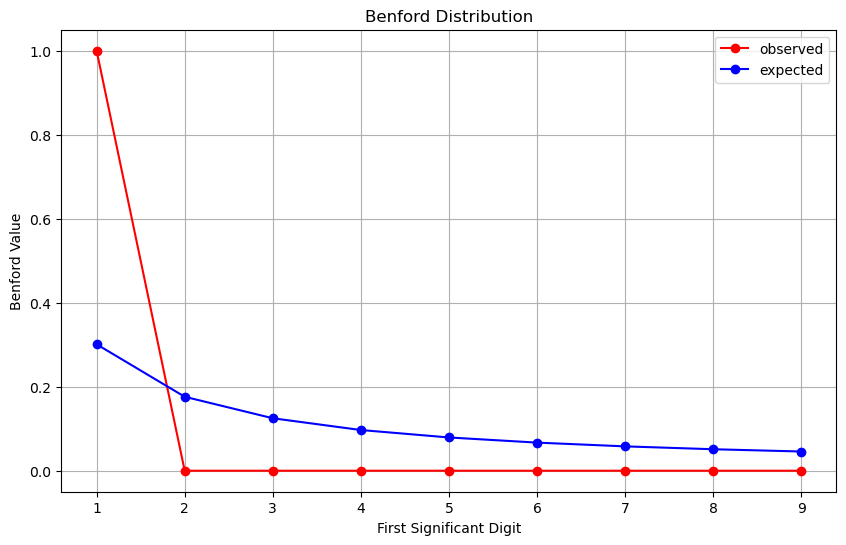

In [22]:
# Define the function to calculate flow size difference
def calculate_flow_size_difference(flow_sizes):
    flow_size_difference = []
    for i in range(1, len(flow_sizes)):
        difference = abs(flow_sizes[i] - flow_sizes[i-1])
        flow_size_difference.append(difference)
    return flow_size_difference

# Calculate flow size difference for a specific column
flow_size_diff = calculate_flow_size_difference(np.array(df['prt_dst'][0:1000]))

# Function to extract first significant digit and handle zero values
def extract_first_significant_digit(flow_size_diff):
    first_digits = []
    for diff in flow_size_diff:
        if diff == 0:
            continue
        first_digit = int(str(diff)[0])
        first_digits.append(first_digit)
    return first_digits

# Extract first significant digit and handle zero values
first_digits = extract_first_significant_digit(flow_size_diff)

# Calculate frequency distribution of first significant digits
first_digit_counts = np.bincount(first_digits)[1:]

# Pad the attack flow count with zeros if needed to ensure both arrays have the same length
if len(first_digit_counts) < 9:
    first_digit_counts = np.pad(first_digit_counts, (0, 9 - len(first_digit_counts)), 'constant')
    
# Calculate percentage distribution
percentage_distribution = (first_digit_counts / len(first_digits))

# Define the function to calculate Inverse-Benford distribution
def benford_distribution(d):
    return math.log10(1 + 1 / d)

# Calculate Inverse-Benford distribution for each digit
benford_distribution_values = [benford_distribution(d) for d in range(1, 10)]

# Plot the Inverse-Benford distribution
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), percentage_distribution, marker='o', color='red', label='observed')
plt.plot(range(1, 10), benford_distribution_values, marker='o', color='blue', label='expected')
plt.title("Benford Distribution")
plt.xlabel("First Significant Digit")
plt.ylabel("Benford Value")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend()
plt.show()


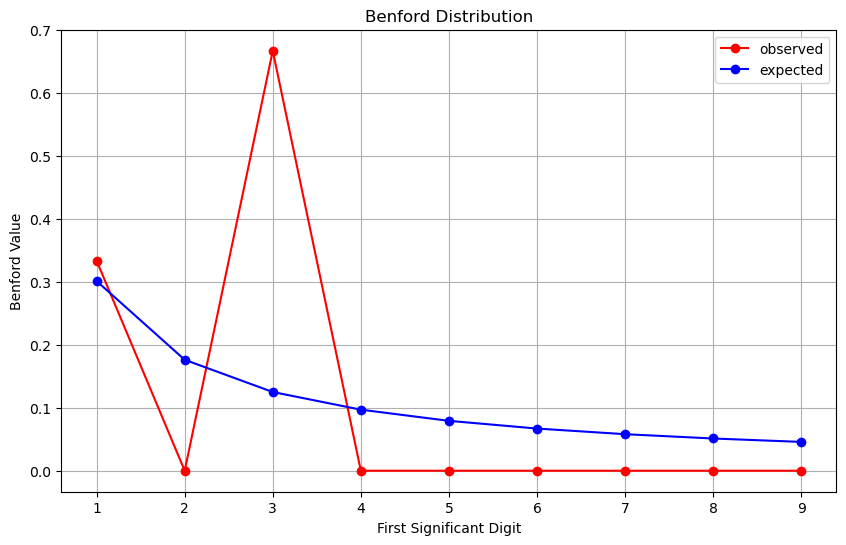

In [21]:
# Define the function to calculate flow size difference
def calculate_flow_size_difference(flow_sizes):
    flow_size_difference = []
    for i in range(1, len(flow_sizes)):
        difference = abs(flow_sizes[i] - flow_sizes[i-1])
        flow_size_difference.append(difference)
    return flow_size_difference

# Calculate flow size difference for a specific column
flow_size_diff = calculate_flow_size_difference(np.array(attack['prt_dst'][0:1000]))

# Function to extract first significant digit and handle zero values
def extract_first_significant_digit(flow_size_diff):
    first_digits = []
    for diff in flow_size_diff:
        if diff == 0:
            continue
        first_digit = int(str(diff)[0])
        first_digits.append(first_digit)
    return first_digits

# Extract first significant digit and handle zero values
first_digits = extract_first_significant_digit(flow_size_diff)

# Calculate frequency distribution of first significant digits
first_digit_counts = np.bincount(first_digits)[1:]

# Pad the attack flow count with zeros if needed to ensure both arrays have the same length
if len(first_digit_counts) < 9:
    first_digit_counts = np.pad(first_digit_counts, (0, 9 - len(first_digit_counts)), 'constant')

# Calculate percentage distribution
percentage_distribution = (first_digit_counts / len(first_digits))

# Define the function to calculate Inverse-Benford distribution
def benford_distribution(d):
    return math.log10(1 + 1 / d)

# Calculate Inverse-Benford distribution for each digit
benford_distribution_values = [benford_distribution(d) for d in range(1, 10)]

# Plot the Inverse-Benford distribution
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), percentage_distribution, marker='o', color='red', label='observed')
plt.plot(range(1, 10), benford_distribution_values, marker='o', color='blue', label='expected')
plt.title("Benford Distribution")
plt.xlabel("First Significant Digit")
plt.ylabel("Benford Value")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend()
plt.show()


In [40]:
attributes = [
    'fwd_mean_iat',
    'bwd_mean_iat',
    'fwd_std_iat',
    'bwd_std_iat'
]


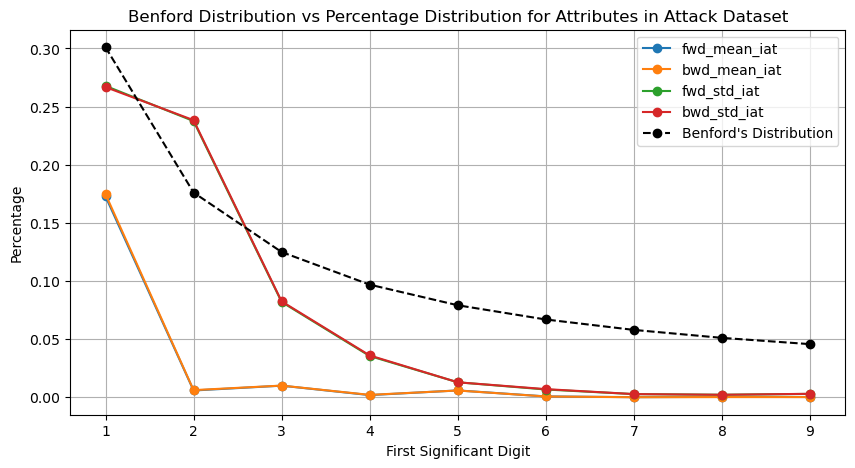

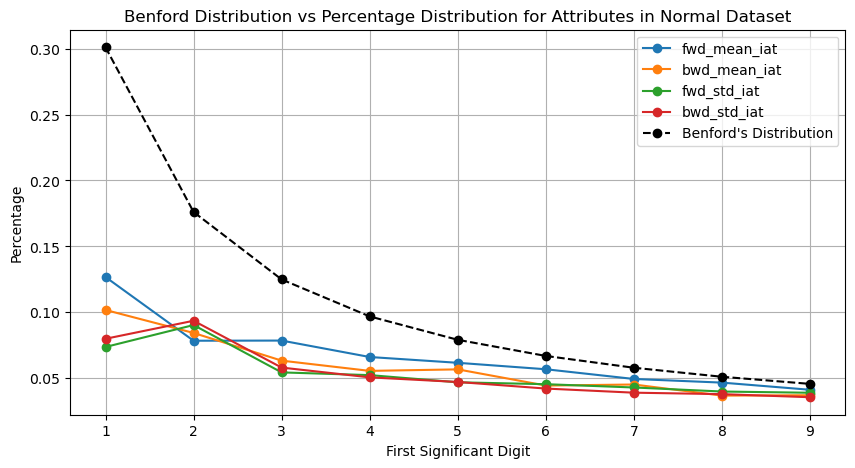

In [30]:
# Function to calculate percentage distribution
def calculate_percentage_distribution(flow_size_diff):
    first_digits = extract_first_significant_digit(flow_size_diff)
    first_digit_counts = np.bincount(first_digits)[1:]
    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts) < 9:
        first_digit_counts = np.pad(first_digit_counts, (0, 9 - len(first_digit_counts)), 'constant')
    return first_digit_counts / len(first_digits)


plt.figure(figsize=(10, 5))

for i, attribute in enumerate(attributes):
    data_attack = attack[attribute]
    flow_size_diff = calculate_flow_size_difference(np.array(data_attack))
    percentage_distribution = calculate_percentage_distribution(flow_size_diff)

    plt.plot(range(1, 10), percentage_distribution, marker='o', label=f'{attribute}')

plt.plot(range(1, 10), benford_distribution_values, marker='o', color='black', linestyle='--', label="Benford's Distribution")
plt.title("Benford Distribution vs Percentage Distribution for Attributes in Attack Dataset")
plt.xlabel("First Significant Digit")
plt.ylabel("Percentage")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))

for i, attribute in enumerate(attributes):
    data_normal = df[attribute]
    flow_size_diff = calculate_flow_size_difference(np.array(data_normal))
    percentage_distribution = calculate_percentage_distribution(flow_size_diff)

    plt.plot(range(1, 10), percentage_distribution, marker='o', label=f'{attribute}')

plt.plot(range(1, 10), benford_distribution_values, marker='o', color='black', linestyle='--', label="Benford's Distribution")
plt.title("Benford Distribution vs Percentage Distribution for Attributes in Normal Dataset")
plt.xlabel("First Significant Digit")
plt.ylabel("Percentage")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend()
plt.show()


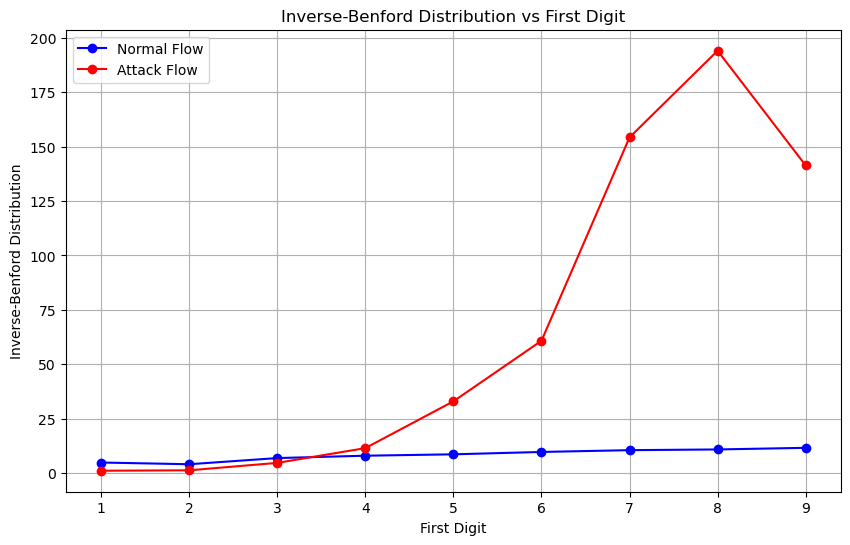

In [31]:
# Define the function to calculate flow size difference
def calculate_flow_size_difference(flow_sizes):
    flow_size_difference = []
    for i in range(1, len(flow_sizes)):
        difference = abs(flow_sizes[i] - flow_sizes[i-1])
        flow_size_difference.append(difference)
    return flow_size_difference

# Calculate flow size difference for normal and attack flows
flow_size_diff_normal = calculate_flow_size_difference(np.array(df['bwd_std_iat']))
flow_size_diff_attack = calculate_flow_size_difference(np.array(attack['bwd_std_iat']))

# Function to extract first significant digit and handle zero values
def extract_first_significant_digit(flow_size_diff):
    first_digits = []
    for diff in flow_size_diff:
        if diff == 0:
            continue
        first_digit = int(str(diff)[0])
        first_digits.append(first_digit)
    return first_digits

# Extract first significant digit and handle zero values for normal and attack flows
first_digits_normal = extract_first_significant_digit(flow_size_diff_normal)
first_digits_attack = extract_first_significant_digit(flow_size_diff_attack)

# Calculate frequency distribution of first significant digits for normal and attack flows
first_digit_counts_normal = np.bincount(first_digits_normal)[1:]
first_digit_counts_attack = np.bincount(first_digits_attack)[1:]

# Pad the attack flow count with zeros if needed to ensure both arrays have the same length
if len(first_digit_counts_attack) < 9:
    first_digit_counts_attack = np.pad(first_digit_counts_attack, (0, 9 - len(first_digit_counts_attack)), 'constant')

# Calculate percentage distribution for normal and attack flows
percentage_distribution_normal = (first_digit_counts_normal / len(first_digits_normal))
percentage_distribution_attack = (first_digit_counts_attack / len(first_digits_attack))

# Calculate Inverse-Benford distribution for each digit
inverse_benford_distribution_values_normal = [inverse_benford_distribution(f) for f in percentage_distribution_normal]
inverse_benford_distribution_values_attack = [inverse_benford_distribution(f) for f in percentage_distribution_attack]

# Plot the Inverse-Benford distribution
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inverse_benford_distribution_values_normal, marker='o', color='blue', label='Normal Flow')
plt.plot(range(1, 10), inverse_benford_distribution_values_attack, marker='o', color='red', label='Attack Flow')
plt.title("Inverse-Benford Distribution vs First Digit")
plt.xlabel("First Digit")
plt.ylabel("Inverse-Benford Distribution")
plt.xticks(range(1, 10))
plt.grid(True)
plt.legend()
plt.show()

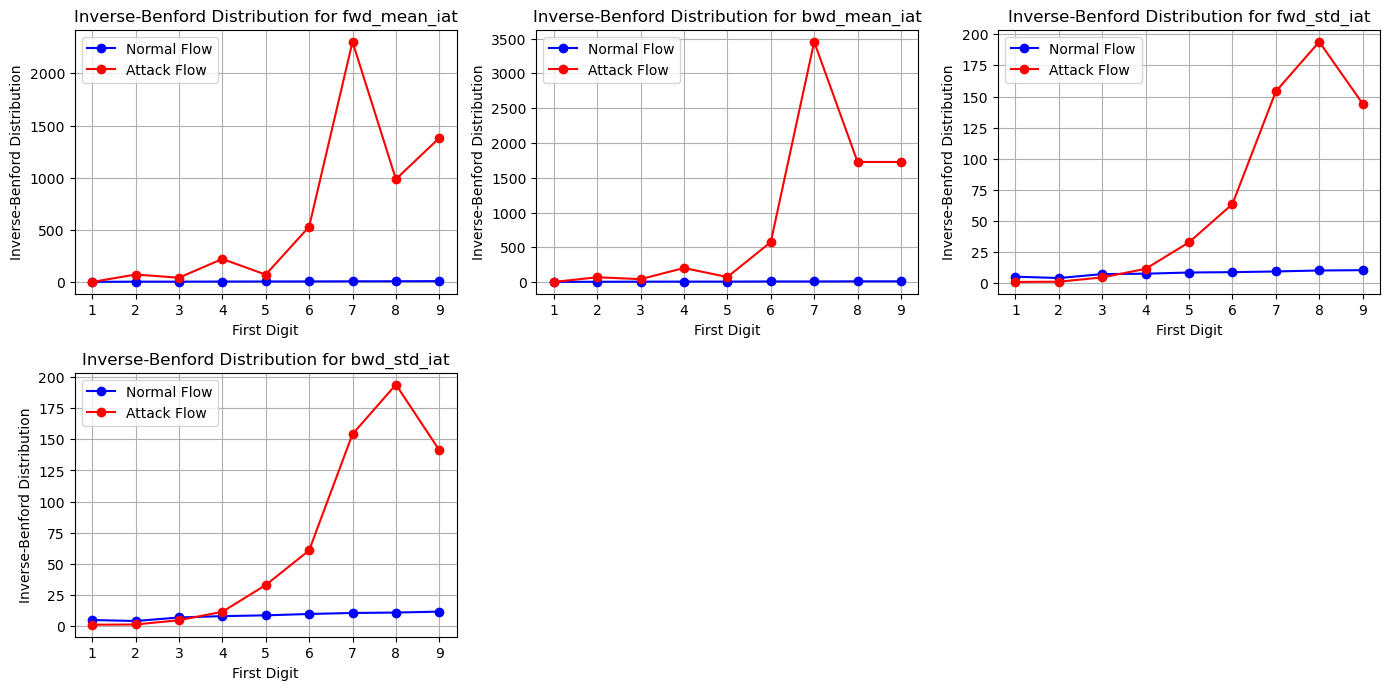

In [32]:
# Define the function to calculate Inverse-Benford distribution
def inverse_benford_distribution(frequency):
    return 1 / (10**(frequency) - 1)

def calculate_inverse_benford_distribution(data_normal, data_attack):
    # Calculate flow size difference for normal and attack flows
    flow_size_diff_normal = calculate_flow_size_difference(np.array(data_normal))
    flow_size_diff_attack = calculate_flow_size_difference(np.array(data_attack))

    # Extract first significant digit and handle zero values for normal and attack flows
    first_digits_normal = extract_first_significant_digit(flow_size_diff_normal)
    first_digits_attack = extract_first_significant_digit(flow_size_diff_attack)

    # Calculate frequency distribution of first significant digits for normal and attack flows
    first_digit_counts_normal = np.bincount(first_digits_normal)[1:]
    first_digit_counts_attack = np.bincount(first_digits_attack)[1:]

    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts_normal) < 9:
        first_digit_counts_normal = np.pad(first_digit_counts_normal, (0, 9 - len(first_digit_counts_normal)), 'constant')
    
    # Pad the attack flow count with zeros if needed to ensure both arrays have the same length
    if len(first_digit_counts_attack) < 9:
        first_digit_counts_attack = np.pad(first_digit_counts_attack, (0, 9 - len(first_digit_counts_attack)), 'constant')

    # Calculate percentage distribution for normal and attack flows
    percentage_distribution_normal = (first_digit_counts_normal / len(first_digits_normal))
    percentage_distribution_attack = (first_digit_counts_attack / len(first_digits_attack))

    # Calculate Inverse-Benford distribution for each digit
    inverse_benford_distribution_values_normal = [inverse_benford_distribution(f) for f in percentage_distribution_normal]
    inverse_benford_distribution_values_attack = [inverse_benford_distribution(f) for f in percentage_distribution_attack]

    return inverse_benford_distribution_values_normal, inverse_benford_distribution_values_attack

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

plt.figure(figsize=(14, 10))

for i, attribute in enumerate(attributes):
    data_normal = df[attribute]
    data_attack = attack[attribute]
    
    inverse_benford_distribution_values_normal, inverse_benford_distribution_values_attack = calculate_inverse_benford_distribution(data_normal, data_attack)
    
    plt.subplot(3, 3, i+1)
    plt.plot(range(1, 10), inverse_benford_distribution_values_normal, marker='o', color='blue', label='Normal Flow')
    plt.plot(range(1, 10), inverse_benford_distribution_values_attack, marker='o', color='red', label='Attack Flow')
    plt.title(f"Inverse-Benford Distribution for {attribute}")
    plt.xlabel("First Digit")
    plt.ylabel("Inverse-Benford Distribution")
    plt.xticks(range(1, 10))
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()
